# Bank Marketing Subscription Problem
In this notebook, we'll be tackling a marketing problem, where based on the user's information, we would be meant to try to predict whether or not they would be interested in the bank's campaign

### 1. Identification of variables and data types

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("archive/bank-full.csv", sep=",")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
print(data.shape)

(45211, 17)


We see we have a grand total of 45 thousand elements in our set, with 17 properties, one of them being the outcome for our problem ("Target" - label to be predicted), the remaining 16 are the features available on each example.

In [3]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

Regarding the Data Types, despite Python returning this informations, this is not quite what we are looking for.

Instead, we need to analyze the data in a another way.

As such, we got:

- age -> Numeric Attribute (Ratio-Scaled) | Client's Age
- job -> Categorical Attribute (Nominal) | Client's Job
- marital -> Categorial (Nominal) | Client's Marital Status
- education -> Categorial (Ordinal) | Education Level
- default -> Categorial (Nominal) | Whether the Client's Credit is in default
- balance -> Numeric (Ratio-Scaled) | Balance in Client's Account
- housing -> Categorical (Nominal) | Whether the Client has a Housing Loan
- loan -> Categorial (Nominal) | Whether the Client has a personal Loan
- contact -> Categorial (Nominal) | Type of Client's contact
- day -> Numeric (Ratio) | When was last contact with the client
- month -> Categorical (Ordinal) | Same as above
- duration -> Numeric (Ratio) | How long las contact lasted
- campaing -> Numeric (Ratio) | How many times client was contacted about this campaing
- Pdays -> Numerical (Ratio) | how many days it has past since the client was last contacted (-1 means the client wasn’t contacted yet)
- Previous -> Numerical (Ratio) | how many times the client has been contacted about previous campaign
- Poutcome -> Categorical (???) | outcome of a past telemarketing deal: success, failure, other or unknown

Features like housing, which can only have 2 values, can also be named "dichotomous".

### 2. Statistical Univariate Analysis.

In [4]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


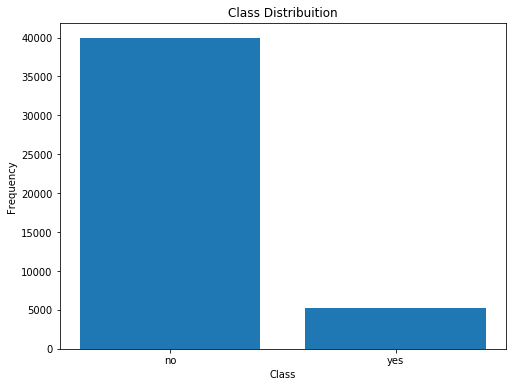

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data.rename(columns = {'Target': 'y'}, inplace = True)

plt.figure(figsize=(8,6))
plt.bar(data.y.unique(), data['y'].value_counts())
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.title("Class Distribuition")
plt.show()

Therefore one can conclude the DS is non-balanced!

In [6]:
def group_by_feature(feature):
  grouped = data.groupby([feature, 'y']).size()
  plt.figure(figsize=(20,6))
  plt.bar(data[feature].unique(), grouped[grouped.index.isin(['no'], level=1)], align='center')
  plt.bar(data[feature].unique(), grouped[grouped.index.isin(['yes'], level=1)], align='center')
  plt.xlabel(feature)
  plt.ylabel("Frequency")
  plt.legend(['no', 'yes'])
  plt.title('Feature ' + feature + " Frequency")
  plt.show()

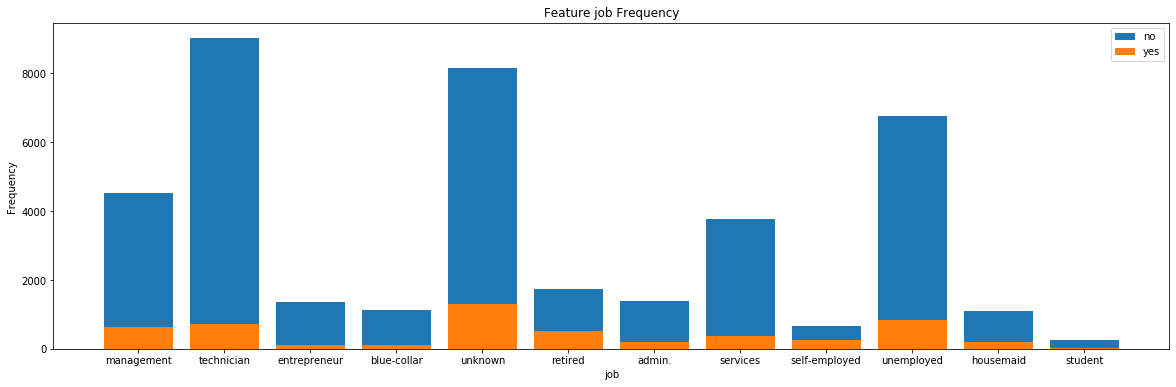

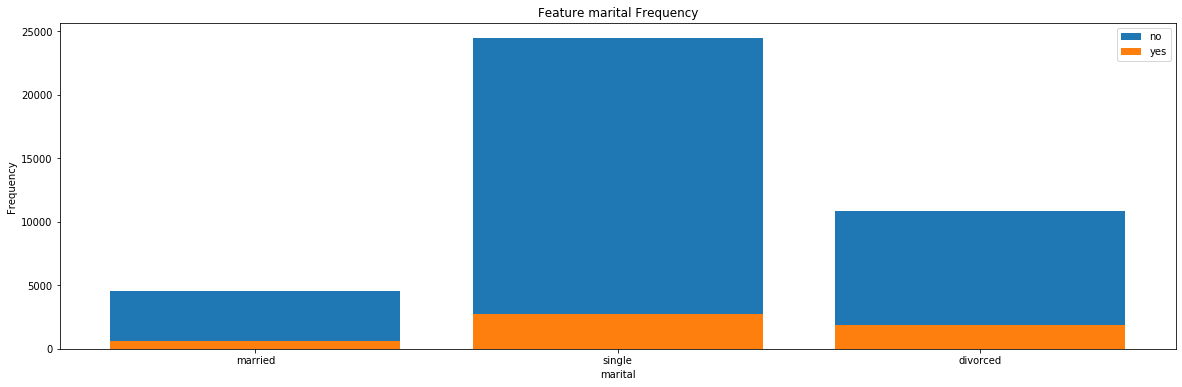

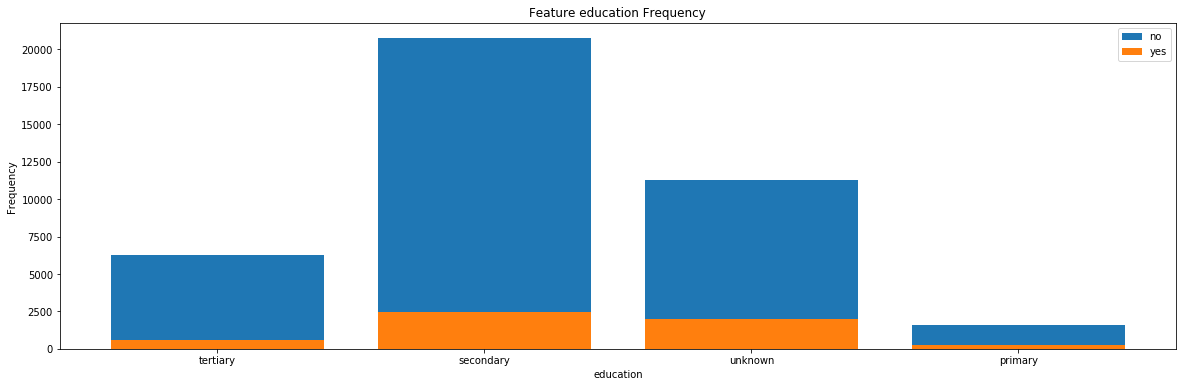

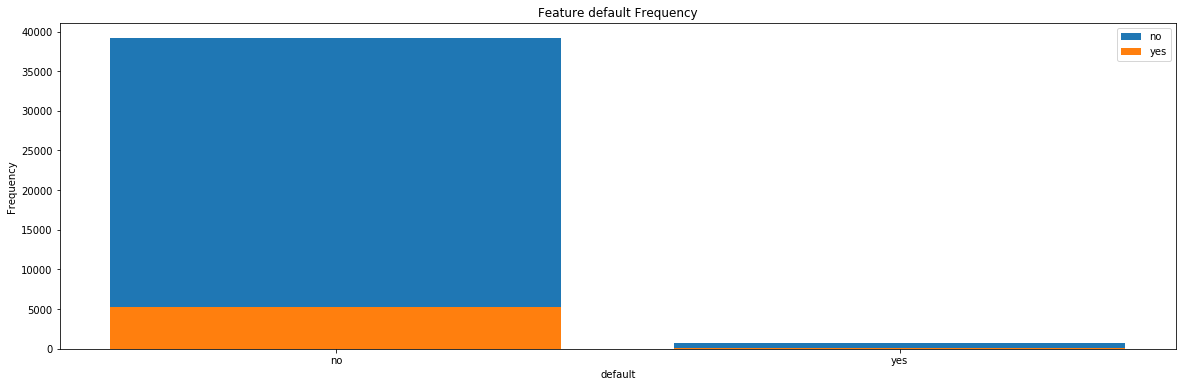

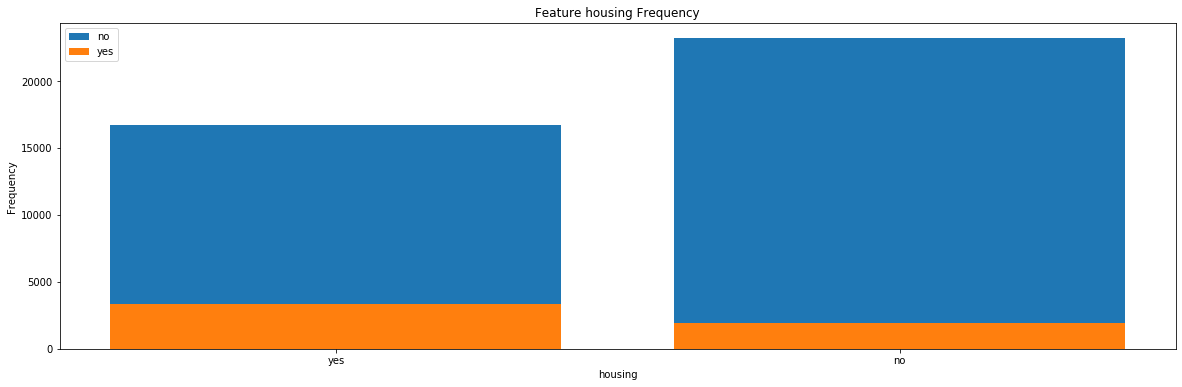

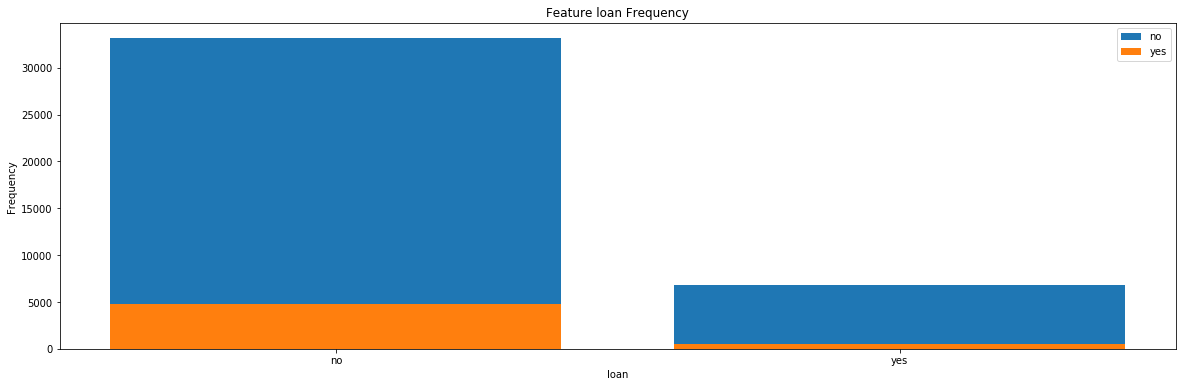

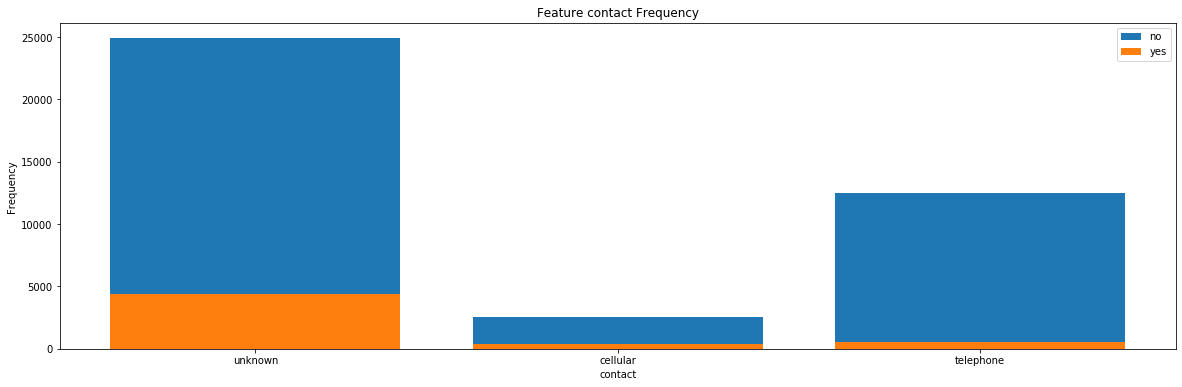

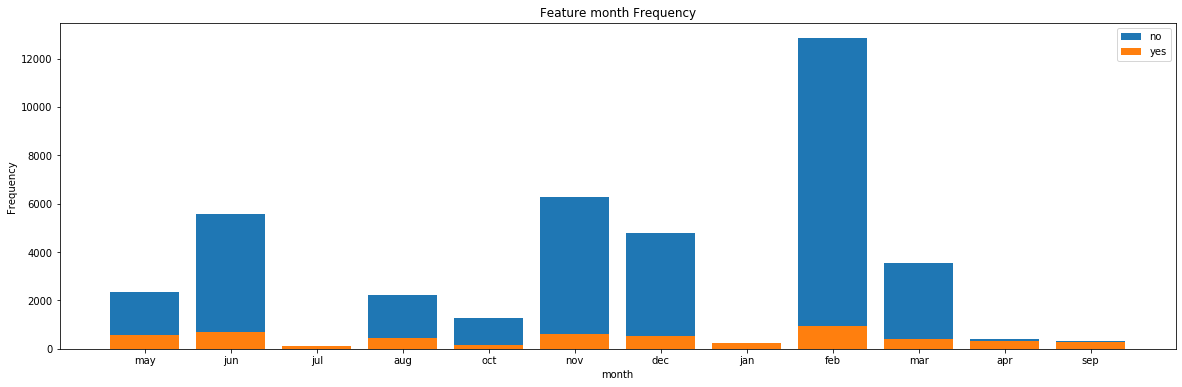

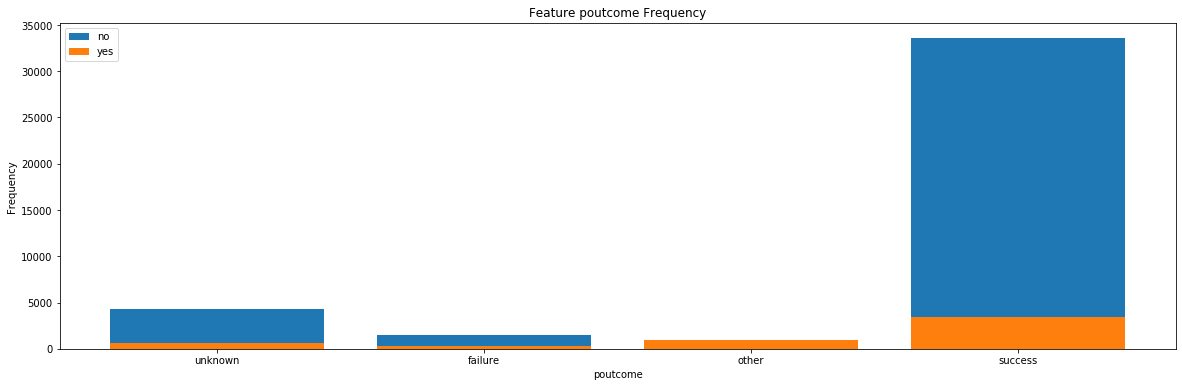

In [7]:
for col in data.columns:
    if data[col].dtype != np.int64 and col != 'y':
        group_by_feature(col)

Due to the fact the dataset had way more samples from the "negative" class, it doesn't come as a surprise that the majority of each of the previous features belongs to that same class.

However, looking at _poutcome_, one can conclude that if the value of a new sample is "other", it will most likely belong to the "positive" class.

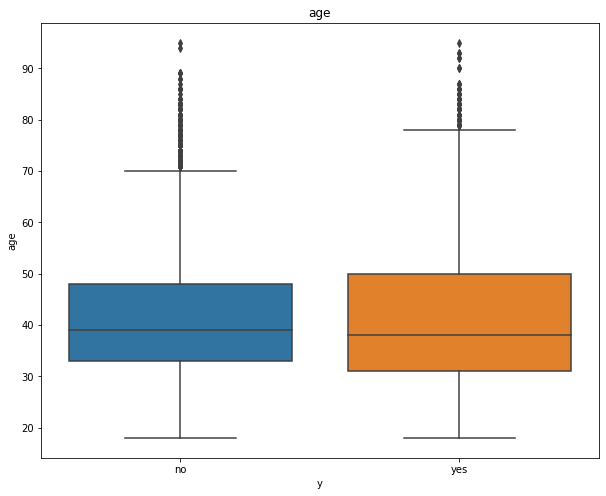

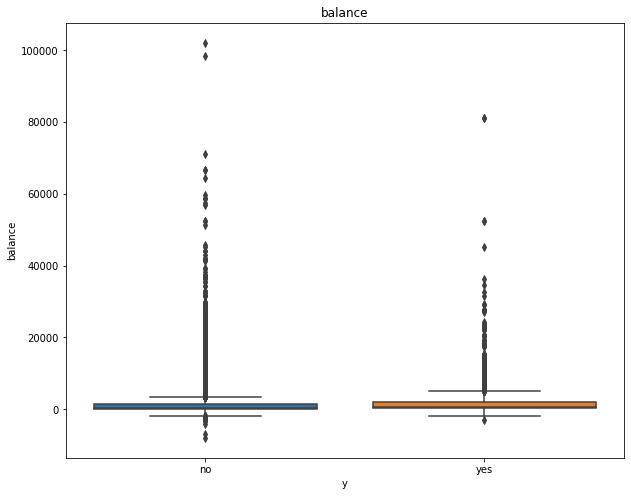

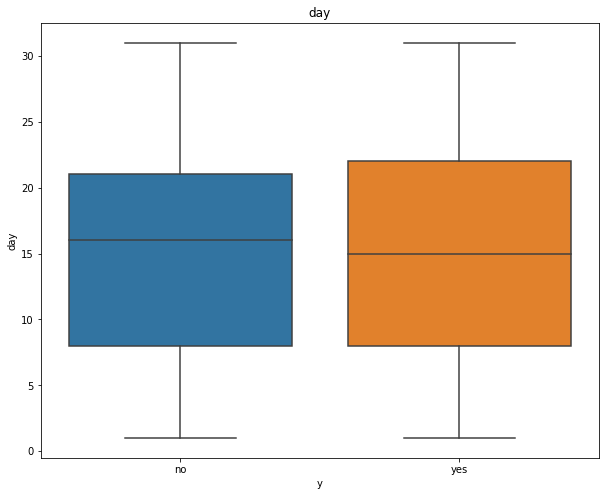

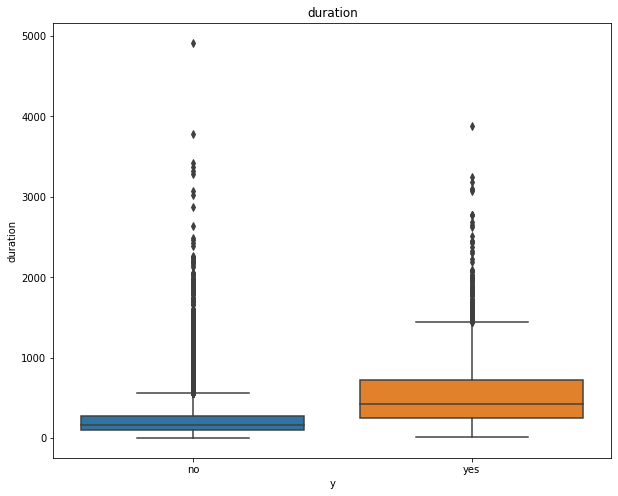

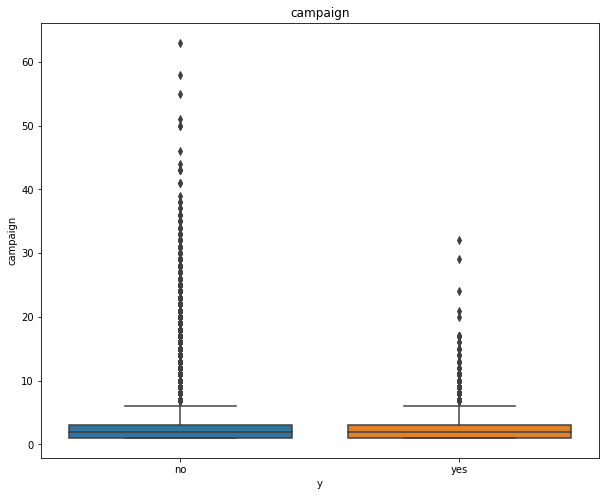

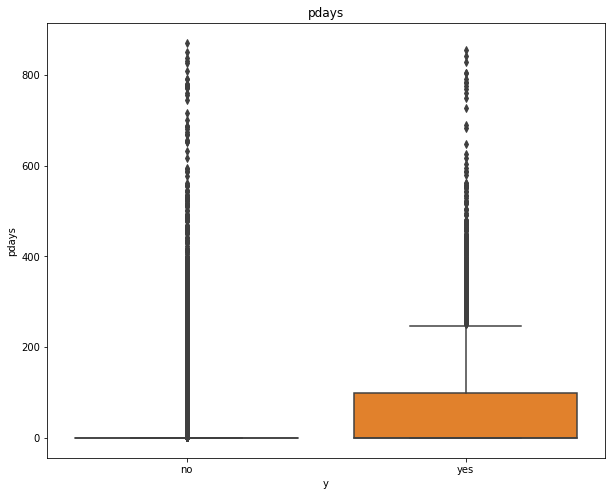

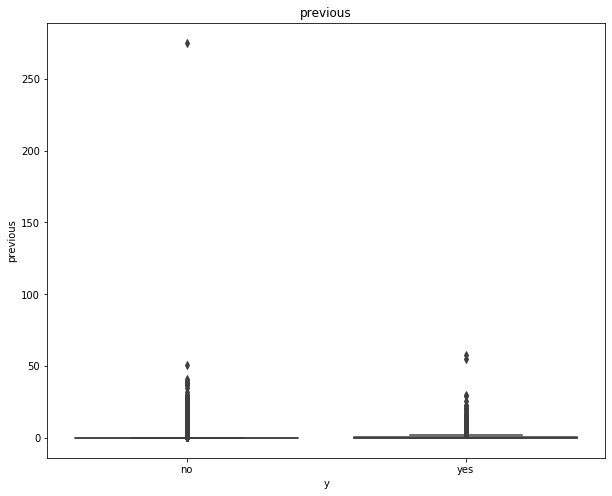

In [8]:
import seaborn as sns

for col in data.columns:
    if data[col].dtype == np.int64 and col != 'y':
        plt.figure(figsize=(10, 8))
        sns.boxplot(data=data, x="y", y=col).set_title(col)

Using boxplot, it is posible to get a grasp of the features with the most outliners(?) and the overall distribuition of data per feature.

### 3. Missing value treatment

#### Drop Duplicates

In [9]:
data.drop_duplicates()
data.shape

(45211, 17)

As it can be seen, there are no duplicates in the present dataset.

#### Check Nulls (Missing Values)

In [10]:
missing = data.isnull().values.any()
print("Missing Values? ", missing)

Missing Values?  False


Similarly, there are no missing values.

### 4. Variable Transformation

Because the dataset has many features of the Categorical type, it is important to transform them to a numerical form, such that they are easier understandable for the algorithms to work with.

#### Convert Categorical - Nominal to Numerical

Based on the classification done above, we must now pick the Nominal datatypes, and convert them to numbers. 

Because this type of data works purely as "labels", they have no numerical significance, and as such, each label can be atributed any number.

To archieve this task, many methods can me choosen:
- Find and Replace: for each different value, manually attribute them a different number;
- Label Encoding: the methoc picked here, in which in a automatic way, the values are given a number;
- One Hot Encoding: covers the disavantadge of the previous option, in which numeric values can be “misinterpreted” by the algorithms, by giving some values more "weight" than others. The basic strategy is to convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly but does have the downside of adding more columns to the data set.

Having in consideration that we are dealing with Nominal data, and that the dataset has a considerable size, it was decided to use the 2nd aproach, as the 3rd one would take a lot of memory and create potentially sparse tables.

In [11]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [12]:
for col in data.columns:
    if data[col].dtype != np.int64 and col not in ['y', 'education', 'month']:
        data[col] = data[col].astype('category')
        data[col] = data[col].cat.codes

In [13]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,tertiary,0,2143,1,0,2,5,may,261,1,-1,0,3,no
1,44,9,2,secondary,0,29,1,0,2,5,may,151,1,-1,0,3,no
2,33,2,1,secondary,0,2,1,1,2,5,may,76,1,-1,0,3,no
3,47,1,1,unknown,0,1506,1,0,2,5,may,92,1,-1,0,3,no
4,33,11,2,unknown,0,1,0,0,2,5,may,198,1,-1,0,3,no


#### Convert Ordinal to Numerical

On the other hand, to convert Ordinal data, the best option was considered to be Find and Replace.

Additionally, we take the opportunity to also convert the y (label to be predicted) collumn.

In [14]:
cleanup_nums = {"education":     {"tertiary": 3, "secondary": 2, "primary": 1, "unknown": -1},
                "month": {'jan': 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12},
                "y": {"no": 0, "yes": 1}}

data.replace(cleanup_nums, inplace=True)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,3,0,2143,1,0,2,5,5,261,1,-1,0,3,0
1,44,9,2,2,0,29,1,0,2,5,5,151,1,-1,0,3,0
2,33,2,1,2,0,2,1,1,2,5,5,76,1,-1,0,3,0
3,47,1,1,-1,0,1506,1,0,2,5,5,92,1,-1,0,3,0
4,33,11,2,-1,0,1,0,0,2,5,5,198,1,-1,0,3,0


#### Normalization

In [15]:
#print(data["job"].value_counts())
print(data["job"].min())
print(data["job"].max())
def min_max_normalization(matrix):
    for col in matrix.columns:
        if col != "y":
            matrix[col] = (matrix[col] - matrix[col].min()) / (matrix[col].max() - matrix[col].min())

min_max_normalization(data)

0
11


In [16]:
#data.head() 
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.519481,0.363636,0.5,1.00,0.0,0.092259,1.0,0.0,1.0,0.133333,0.363636,0.053070,0.000000,0.000000,0.000000,1.000000,0
1,0.337662,0.818182,1.0,0.75,0.0,0.073067,1.0,0.0,1.0,0.133333,0.363636,0.030704,0.000000,0.000000,0.000000,1.000000,0
2,0.194805,0.181818,0.5,0.75,0.0,0.072822,1.0,1.0,1.0,0.133333,0.363636,0.015453,0.000000,0.000000,0.000000,1.000000,0
3,0.376623,0.090909,0.5,0.00,0.0,0.086476,1.0,0.0,1.0,0.133333,0.363636,0.018707,0.000000,0.000000,0.000000,1.000000,0
4,0.194805,1.000000,1.0,0.00,0.0,0.072812,0.0,0.0,1.0,0.133333,0.363636,0.040260,0.000000,0.000000,0.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.818182,0.5,1.00,0.0,0.080293,0.0,0.0,0.0,0.533333,0.909091,0.198658,0.032258,0.000000,0.000000,1.000000,1
45207,0.688312,0.454545,0.0,0.50,0.0,0.088501,0.0,0.0,0.0,0.533333,0.909091,0.092721,0.016129,0.000000,0.000000,1.000000,1
45208,0.701299,0.454545,0.5,0.75,0.0,0.124689,0.0,0.0,0.0,0.533333,0.909091,0.229158,0.064516,0.212156,0.010909,0.666667,1
45209,0.506494,0.090909,0.5,0.75,0.0,0.078868,0.0,0.0,0.5,0.533333,0.909091,0.103294,0.048387,0.000000,0.000000,1.000000,0


In [17]:
print(data["age"].min(), data["age"].max())
print(data["job"].min(), data["job"].max())
print(data["marital"].min(), data["marital"].max())
print(data["pdays"].min(), data["pdays"].max())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


As it can be observed, each columns has now values between 0 and 1.

Normalizing data, allows not only for a faster learning phase, but also make so that features with otherwise bigger values, don't have bigger influence in the model.

#### Dataset Separation

Finally, just as example, we should now be able to split the data for the learning phase that comes nextly.

In [18]:
from sklearn.model_selection import train_test_split
x_rest, x_test, y_rest, y_test = train_test_split(data.loc[:, data.columns != 'y'], data['y'], test_size=0.2)
x_train, x_cv, y_train, y_cv = train_test_split(x_rest, y_rest, test_size=0.25)
print("Sizes of the sets: ")
print("\tTrain features:", x_train.shape)
print("\tTrain label:", y_train.shape)
print("\tCV features:", x_cv.shape)
print("\tCV label:", y_cv.shape)
print("\tTest features:", x_test.shape)
print("\tTest label:", y_test.shape)

Sizes of the sets: 
	Train features: (27126, 16)
	Train label: (27126,)
	CV features: (9042, 16)
	CV label: (9042,)
	Test features: (9043, 16)
	Test label: (9043,)
